*    change architecture (done)

*    implement all the metrics in the training

*    set checkpoints to save the best model for every metric

*    create dataset division according to the patient (done in
preprocessed)

Haundaroff metric to evaluate boundaries

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


N.B: During all phases of work, except for the debugged training, use Runtime without accelerator. During actual training, set the GPU as a runtime accelerator and disconnect the GPU after each process to avoid Colab GPU restrictions due to runtime limitations.

## Dependencies

In [17]:
#Dependencies to load the dataset in tf.data format
!pip install med_dataloader==0.1.12 -q

In [18]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH)

Mounted at /content/gdrive


In [19]:
ROOT_PATH

'/content/gdrive'

#**Project Workshop Notebook**
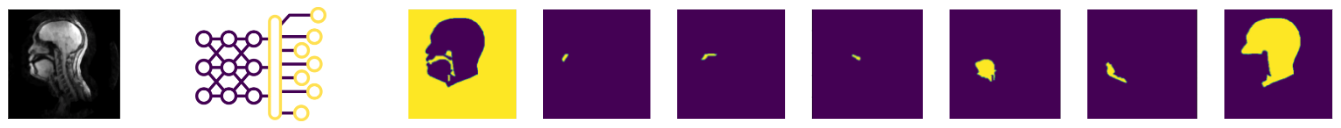

In [20]:
#Possible usefull dependencies
import med_dataloader as mdl
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras

from datetime import datetime
from dateutil.tz import gettz
import SimpleITK as sitk

import scipy
import cv2

# Clear any logs from previous runs
%rm -rf ./logs/

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [21]:
WD_PATH = os.path.join(ROOT_PATH,'MyDrive','workshop', 'ProjectWorkshop_2324')

DATASET_PATH = os.path.join(WD_PATH, 'Dataset', 'Dataset_SP') #Move the folder containig dataset (e.g. Dataset_SP) into WD_PATH
UNCACHED_DATASET_PATH =  os.path.join(WD_PATH, 'Dataset', 'Uncached Dataset', 'SP_images')
MODELS_PATH = os.path.join(WD_PATH, 'Models') #Folder where best trained models will be saved
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)


#...

FileNotFoundError: ignored

In [15]:
# list of unchached images' file name
images = os.listdir(UNCACHED_DATASET_PATH)


# exctract the subjects
subjects = set(i[:6] for i in images)#for every image I taked the ID of the subject. The set will delete duplicates
subjects = sorted(list(subjects))
print(subjects)



# count the images for each subject
images_for_subjects = {}
for sub in subjects:
  images_for_subjects[sub] = 0
for image in images:
    id = image[:6]
    images_for_subjects[id]+=1
images_for_subjects

FileNotFoundError: ignored

## Data Loader

tf.data --> numpy.array

In [ ]:
#Parameters as global variables
NUM_CLASSES = 7
BATCH_SIZE = 8
EPOCHS = 70

#Data augmentation *args (not necessary)
DATA_AUGMENTATION = False
ROTATION = False
FLIP = False
CROP_SIZE = None

#Percentages for dataset splitting
PERC_TRAIN_DATA = 1             #Percentage of the total dataset that will be used for training --> backpropagation and updating of weights and bias are based only on this data
PERC_VALIDATION_DATA = 0          #Percentage of the total dataset that will be used during training to evaluate if the Net is overfitting
PERC_TEST_DATA = 0                #Percentage of the total dataset that will be used after training to evaluate the global Net performances


"""
train_ds, validation_ds, test_ds are iterators wich contains:
        1) tensors of shape [BATCH_SIZE, x, y, CHANNELS] for MRI images,
        2) tensors of shape [BATCH_SIZE, x, y, NUM_CLASSES] for labels.

divided according to the percentages
"""

ds_tot,_,_ = mdl.get_dataset(data_dir = DATASET_PATH,
                                                    percentages = [PERC_TRAIN_DATA, PERC_VALIDATION_DATA, PERC_TEST_DATA],
                                                    batch_size = BATCH_SIZE,
                                                    train_augmentation = DATA_AUGMENTATION,
                                                    random_crop_size = CROP_SIZE,
                                                    random_rotate = ROTATION,
                                                    random_flip = FLIP,
                                                    )


"""
for simplicity we itrate over the abovementioned iterators to fill the numpy tensors.
Iterators are faster and more efficient than numpy.array, but to be manipulated (e.g. preprocessing)
they require high-level python programming, for this reason you will manipulate numpy.array.
"""
#Empty lists filled from the 3 cicles
images_list = []
labels_list = []
i = 0
for img, lbl in ds_tot.unbatch():
    images_list.append(img)
    labels_list.append(lbl)
    i += 1

#From list to tensor
images_array = np.asarray(images_list)
labels_array = np.asarray(labels_list)

#Some info
print('images_shape: {}  labels shape: {}'.format(images_array.shape, labels_array.shape))

images_shape: (820, 256, 256, 1)  labels shape: (820, 256, 256, 7)


In [ ]:
x_train = images_array[:(images_for_subjects['s00001']+images_for_subjects['s00002'])]
y_train = labels_array[:(images_for_subjects['s00001']+images_for_subjects['s00002'])]
x_val = images_array[(images_for_subjects['s00001']+images_for_subjects['s00002']):(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004'])]
y_val = labels_array[(images_for_subjects['s00001']+images_for_subjects['s00002']):(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004'])]
x_test = images_array[(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004']):(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004']+images_for_subjects['s00005'])]
y_test = labels_array[(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004']):(images_for_subjects['s00001']+images_for_subjects['s00002']+images_for_subjects['s00004']+images_for_subjects['s00005'])]
#Some info
print('x_train shape: {}  y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_val shape: {}  y_val shape: {}'.format(x_val.shape, y_val.shape))
print('x_test shape: {}  y_test shape: {}'.format(x_test.shape, y_test.shape))

x_train shape: (520, 256, 256, 1)  y_train shape: (520, 256, 256, 7)
x_val shape: (150, 256, 256, 1)  y_val shape: (150, 256, 256, 7)
x_test shape: (150, 256, 256, 1)  y_test shape: (150, 256, 256, 7)


NameError: ignored

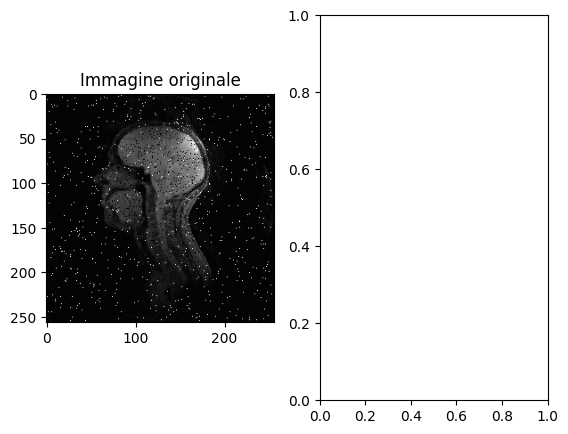

In [ ]:
example_image = x_train[0,:,:,:]
#median filter: it works
img_filtered = cv2.medianBlur(example_image, 3)
img_filtered_5 = cv2.medianBlur(example_image, 5)

hist, bins = np.histogram(img_filtered.flatten(), 2**img_filtered.itemsize, [0, 2**img_filtered.itemsize])
#equalization: don't know
# Calcola la funzione di distribuzione cumulativa
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

# Applica la trasformazione di equalizzazione
equalized_image = np.interp(img_filtered.flatten(), bins[:-1], cdf_normalized).reshape(img_filtered.shape).astype(np.uint16)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(example_image, cv2.COLOR_GRAY2RGB))
plt.title('Immagine originale')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_filtered_3, cv2.COLOR_GRAY2RGB))
plt.title('Immagine filtered')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_filtered_5, cv2.COLOR_GRAY2RGB))
plt.title('Immagine equalized')


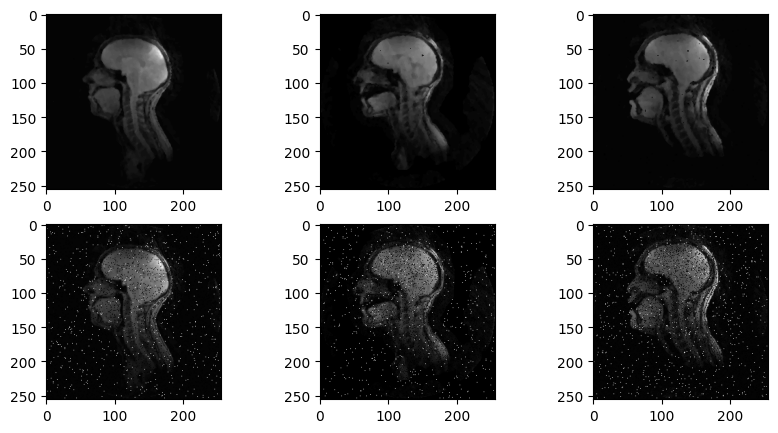

In [ ]:
x_train_median = []

for img in x_train:
  img_filtered = cv2.medianBlur(img, 3)
  x_train_median.append(img_filtered)

x_train_median = np.asarray(x_train_median)



plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(x_train_median[0], cv2.COLOR_GRAY2RGB))

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(x_train_median[300], cv2.COLOR_GRAY2RGB))


plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(x_train_median[600], cv2.COLOR_GRAY2RGB))

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_GRAY2RGB))

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(x_train[300], cv2.COLOR_GRAY2RGB))


plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(x_train[600], cv2.COLOR_GRAY2RGB))




  Img n°: 0 ↓ 


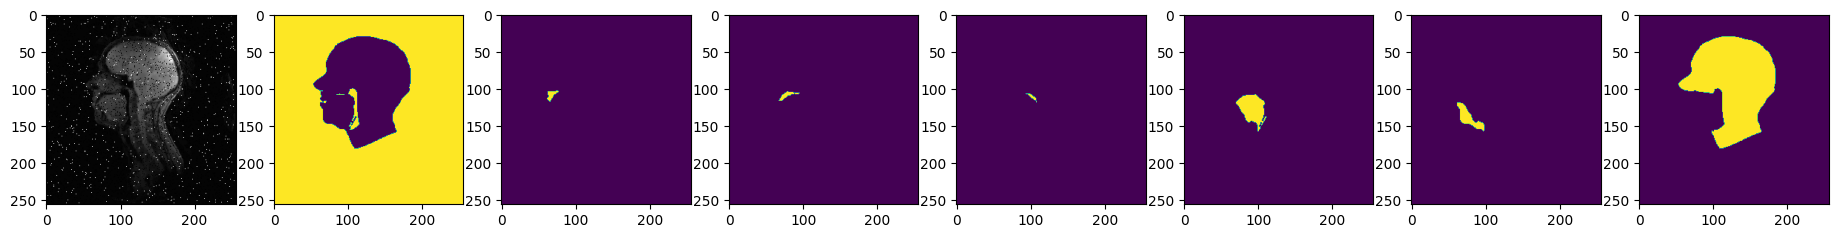

  Img n°: 1 ↓ 


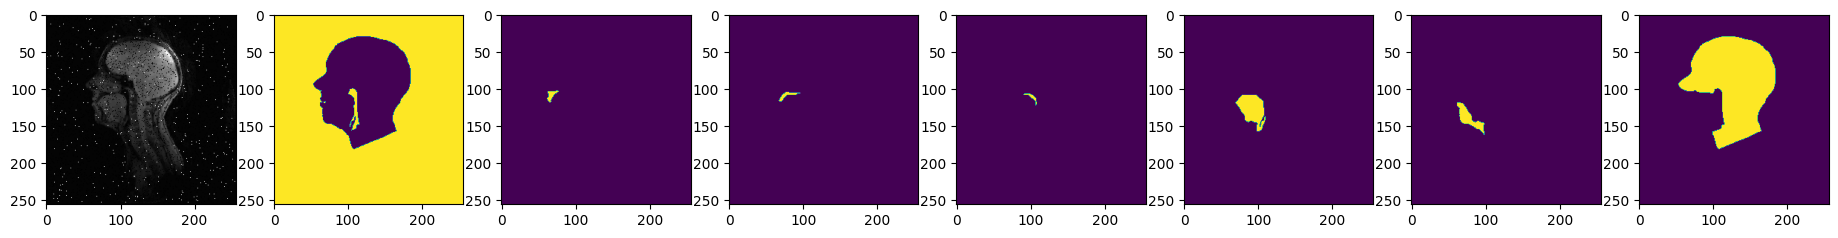

  Img n°: 2 ↓ 


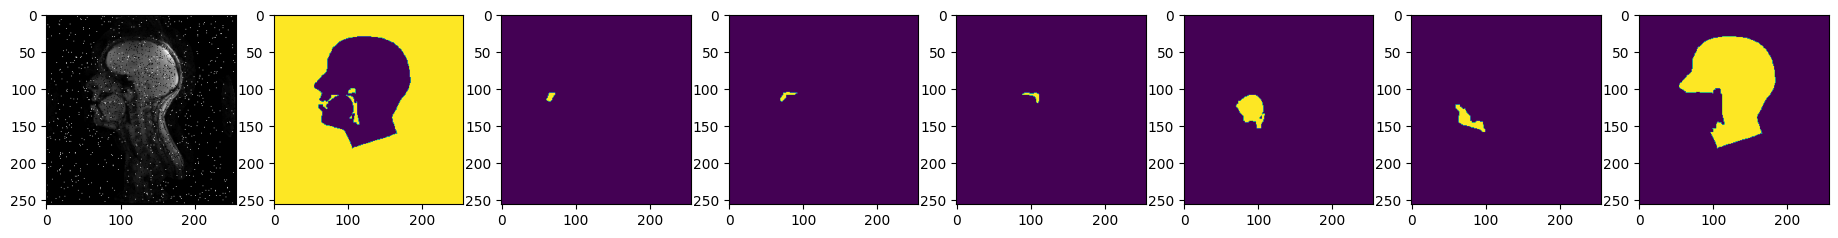

  Img n°: 3 ↓ 


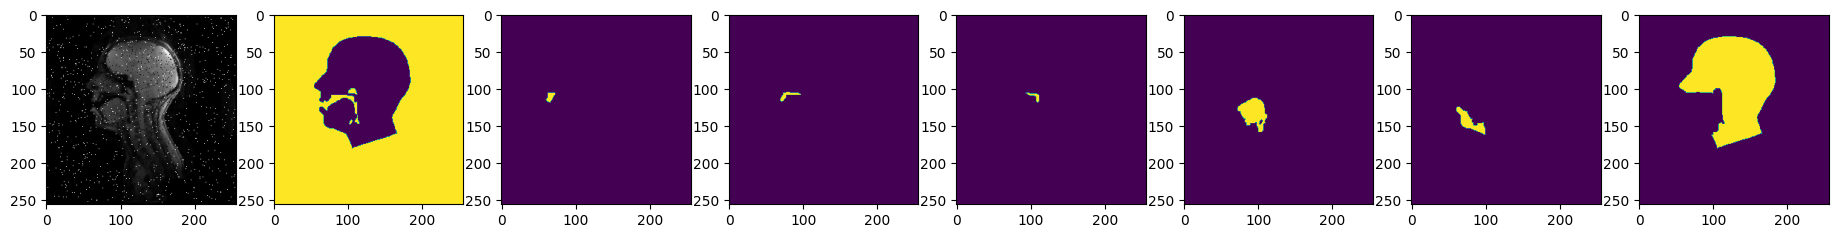

  Img n°: 4 ↓ 


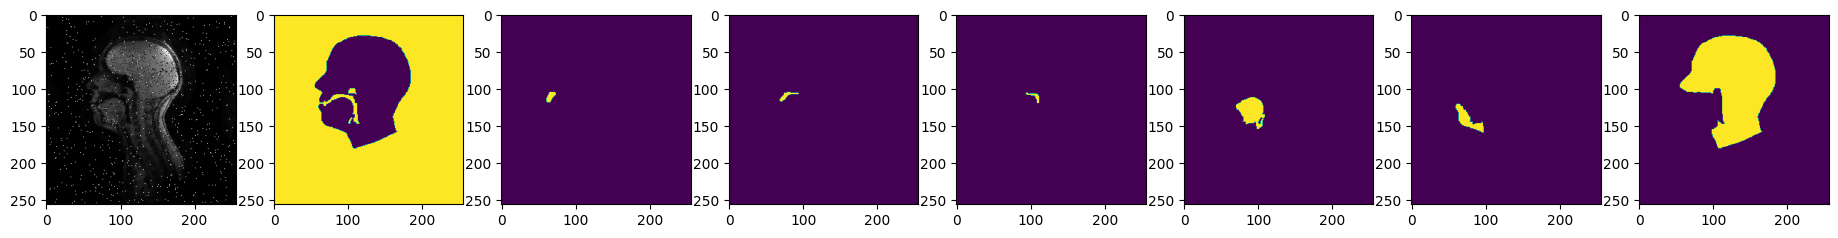

In [ ]:
n = 0
for volume, label in zip(x_train, y_train):
    if n<5:
      print("\033[92m \033[1m Img n°: {} ↓ \033[0m".format(n))
      fig = plt.figure(figsize = [23, 7])
      plt.subplot(1, NUM_CLASSES + 1, 1)
      plt.imshow(volume[:,:,0], cmap="gray")

      for i in range(NUM_CLASSES):
          plt.subplot(1, NUM_CLASSES + 1, i+2)
          plt.imshow(label[:,:,i])

      n += 1
      plt.show(fig)

## Dataset Visualization

## Loss Function

Cross Entropy:  $\, L_{CE} = -\sum_{c=1}^{C} \frac{1}{N} \sum_{i=1}^{N} g_i^c\,log\,p_i^c \quad$ [[1]](https://www.sciencedirect.com/science/article/pii/S1361841521000815)

where:
* $C$ = n°classes
* $N$ = n°pixels of image (256x256)
* $g_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the ground truth label
* $p_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the predicted label

In [ ]:
def cross_entropy(num_classes):
    def loss(y_true, y_pred): #called each iteration (step)

        if len(y_pred.shape) == 4: #2D image
            axis = (1,2)
        elif len(y_pred.shape) == 5: #3D volume
            axis == (1,2,3)

        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        loss_image = 0.0
        loss_ce = 0.0

        for c in range(num_classes):

            loss_image = tf.math.add(-1*(tf.math.reduce_mean(tf.math.multiply(y_true[...,c], tf.math.log(y_pred[...,c] + 1e-9)), axis = axis)), loss_image)

            loss_image = loss_image * np.sum(w) / w[c]

        loss_ce = tf.math.reduce_mean(loss_image)

        return loss_ce

    return loss

#in model.compile can also be set the default tf.keras.losses.CategoricalCrossentropy()

## Metric



Mean Dice: $\, DICE = \frac{1}{C}  \sum_{c = 1}^{C} \frac{2 \lvert S_g^c \cap S_p^c \rvert}{\lvert S_g^c \rvert + \lvert S_p^c \rvert} = \frac{2\,\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c\,p_i^c}{\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c \,+\, \sum_{c=1}^{C}\sum_{i=1}^{N}p_i^c  } \quad$ [[3]](https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-015-0068-x.pdf)

In [ ]:
class Mean_DICE(tf.keras.metrics.Metric):
    def __init__(self,
                 num_classes,
                 name='Mean_DICE',
                 smooth_factor = 1e-9,
                 **kwargs):

        super().__init__(name = name, **kwargs)
        self.num_classes = num_classes
        self.axis = None
        self.smooth_factor = smooth_factor

    def update_state(self, y_true, y_pred, sample_weight=None):

        num_classes = self.num_classes
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        dice_classes = 0.0
        dice_image = 0.

        if len(y_pred.shape) == 4:
            self.axis = (1,2)
        elif len(y_pred.shape) == 5:
            self.axis = (1,2,3)

        for c in range(num_classes):

            abs_label = tf.math.reduce_sum(y_true[...,c], axis = self.axis )
            abs_pred = tf.math.reduce_sum(y_pred[...,c], axis = self.axis )
            MD_batch_denom = tf.math.add(tf.math.add(abs_label, abs_pred), self.smooth_factor)
            MD_batch_num = tf.math.add(2*tf.math.reduce_sum(tf.math.multiply(y_true[...,c], y_pred[...,c]), axis = self.axis), self.smooth_factor)
            dice_image = tf.math.divide(MD_batch_num, MD_batch_denom)
            dice_classes = tf.math.add(dice_image, dice_classes)

        self.mean_dice = tf.math.divide(dice_classes, num_classes)
        self.mean_dice = tf.math.reduce_mean(self.mean_dice)

    def result(self):
        return self.mean_dice

    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @ classmethod
    def from_config(cls, config):
        return cls(**config)

## Architectures

7
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 Conv_Enc_1_0 (Conv2D)       (None, 256, 256, 64)         640       ['Input_Layer[0][0]']         
                                                                                                  
 BatchNorm_0 (BatchNormaliz  (None, 256, 256, 64)         256       ['Conv_Enc_1_0[0][0]']        
 ation)                                                                                           
                                                                                                  
 MaxPool_0 (MaxPooling2D)    (None, 128, 128, 64)         0         ['BatchNorm_0[0][0]'] 

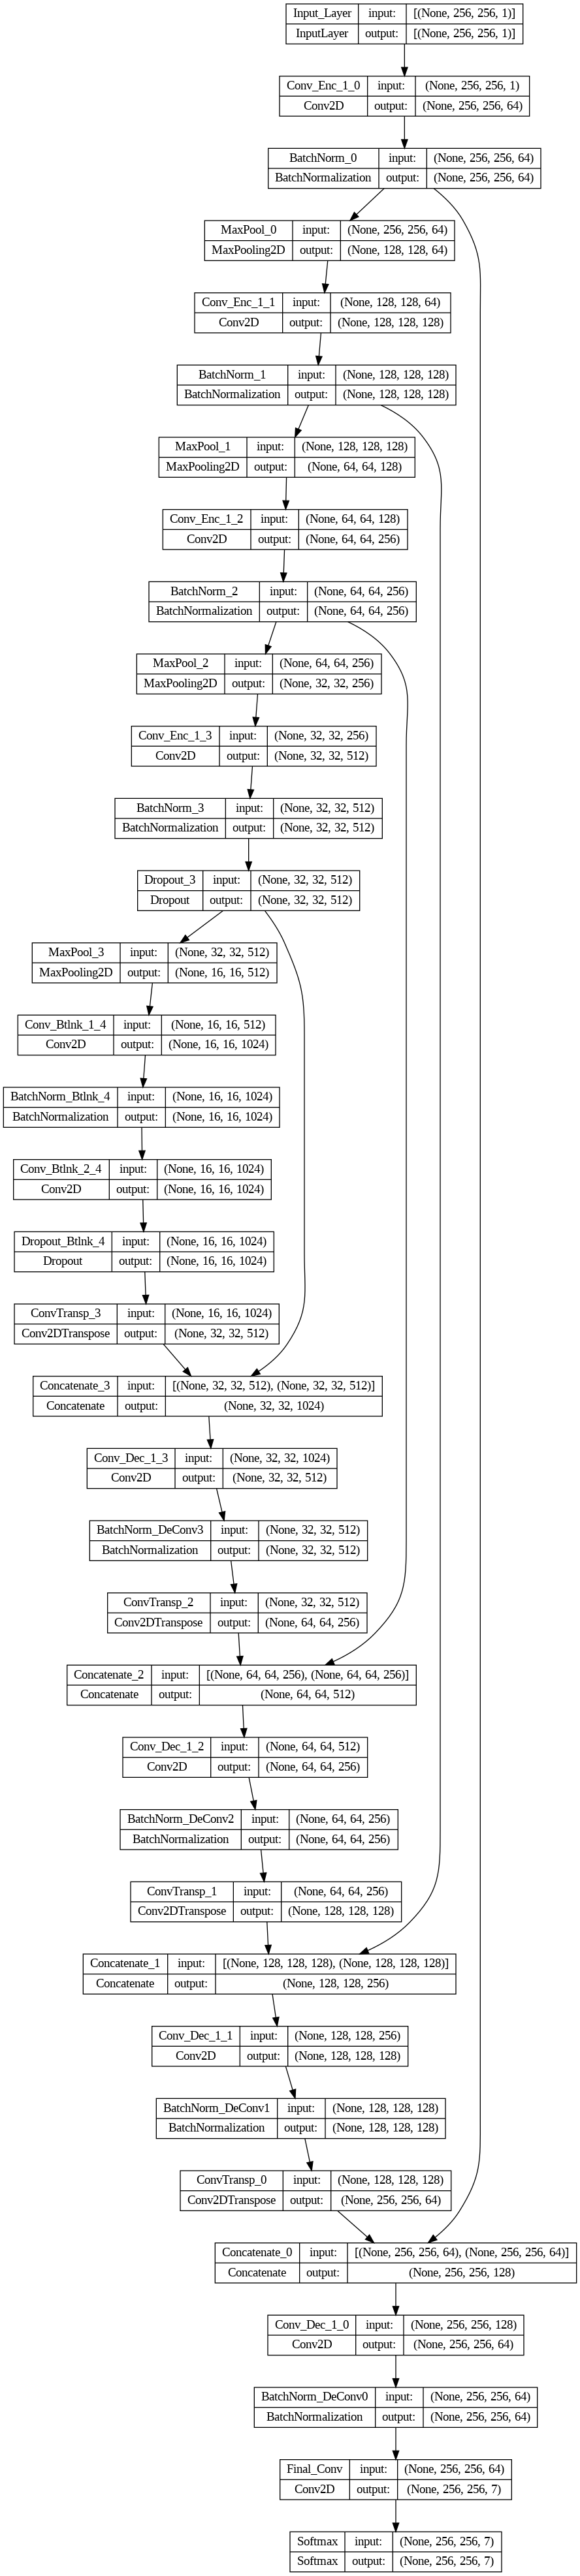

In [ ]:
# Define the U-Net model
def UNet(input_shape, num_classes, depth=4, feature_maps_first=64, kernel_size=3, add_batch_normalization=True, add_dropout=False, dropout_rate=0.5):

    # Define input of the CNN
    temp_layer = keras.Input(shape=input_shape, name='Input_Layer')
    input_layer = temp_layer

    # List storing encoding layers
    encoding_layers = []

    # Initialize the weights with Random and Normal values
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)

    # Encoding Path (Exract image features at different resolution)
    for layer in range(0, depth - 1):
        # Convolutional layers (extract features from images)
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Enc_1_{layer}')(temp_layer)
        if add_batch_normalization == True:
            temp_layer = layers.BatchNormalization(name=f'BatchNorm_{layer}')(temp_layer)

        # Second Convolutional layer in each encoding layer
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Enc_2_{layer}')(temp_layer)
        if add_batch_normalization == True:
            temp_layer = layers.BatchNormalization(name=f'BatchNorm_2{layer}')(temp_layer)
        if add_dropout == True and layer >= depth - 2:
            temp_layer = layers.Dropout(dropout_rate, name=f'Dropout_2{layer}')(temp_layer)


        # Max Pooling Layer (reduce image dimension)

        encoding_layers.append(temp_layer)
        temp_layer = layers.MaxPooling2D(pool_size=(2, 2), name=f'MaxPool_{layer}')(temp_layer)

        print(temp_layer.shape)



    ## Bottleneck
    temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer + 1), kernel_size, activation='relu', padding='same', name=f'Conv_Btlnk_1_{layer + 1}')(temp_layer)
    if add_batch_normalization == True:
      temp_layer = layers.BatchNormalization(name=f'BatchNorm_Btlnk_1{layer + 1}')(temp_layer)
    temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer + 1), kernel_size, activation='relu', padding='same', name=f'Conv_Btlnk_2_{layer + 1}')(temp_layer)
    if add_batch_normalization == True:
      temp_layer = layers.BatchNormalization(name=f'BatchNorm_Btlnk_2{layer + 1}')(temp_layer)
    if add_dropout == True:
      temp_layer = layers.Dropout(dropout_rate, name=f'Dropout_Btlnk_{layer + 1}')(temp_layer)
    print(temp_layer.shape)


    # Decoding path
    for layer in range(depth-2, -1, -1):
        temp_layer = layers.Conv2DTranspose(feature_maps_first * pow(2, layer), kernel_size=2, strides=(2, 2), activation='relu', padding='same', name=f'ConvTransp_{layer}')(temp_layer)
        print(temp_layer.shape)
        temp_layer = layers.concatenate([encoding_layers[layer], temp_layer], axis=3, name=f'Concatenate_{layer}')
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Dec_1_{layer}')(temp_layer)
        if add_batch_normalization == True:
            temp_layer = layers.BatchNormalization(name=f'BatchNorm_DeConv_1{layer}')(temp_layer)
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Dec_2_{layer}')(temp_layer)
        if add_batch_normalization == True:
            temp_layer = layers.BatchNormalization(name=f'BatchNorm_DeConv_2{layer}')(temp_layer)

    # Output Layer
    temp_layer = layers.Conv2D(num_classes, 1, activation='linear', padding='same', name='Final_Conv')(temp_layer)
    output_layer = layers.Softmax(axis=-1, name='Softmax')(temp_layer)

    model = keras.Model(input_layer, output_layer)

    return model

# Define input shape and number of classes
input_shape = (x_train.shape[1], x_train.shape[2], 1)  # Adjust input shape as needed
num_classes = y_train.shape[3]  # Adjust for the number of segmentation classes

# Create the U-Net model
model = UNet(input_shape, num_classes, depth=5, feature_maps_first=64, add_batch_normalization=True, add_dropout=True)

# Print a summary of the model architecture
model.summary()

# Plot U-Net model representation
tf.keras.utils.plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)



## Model Building & Callbacks

In [ ]:
#Define the function to initalize the weights

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate


def initialize_weights(model):
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Conv2DTranspose)):
            # Set kernel initializer for convolutional layers
            layer.kernel_initializer = tf.keras.initializers.he_normal()

In [ ]:

#Build Model --> instantiate the weights of the defined architecture according to the choosen mode

initialize_weights(model)

#model.compile --> define loss, optimizer and metrics to be used during training

model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-8,beta_1=0.9, beta_2=0.999,),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[Mean_DICE()])



# To use binary cross entropy loss function (more suitable for the task) one-hot-encoding is required for the labels.

#add a new path to the segmented model
#segm_model_path = os.path.join(segm_model_folder_path, 'segm_model.h5_1')
# Save the trained model to a file
#model.save(segm_model_path)


#Create a directory tree to neatly save the models
training_path = os.path.join(WD_PATH, 'Training_' + datetime.now(gettz("Europe/Rome")).strftime("%Y-%m-%d-T%H:%M"))
checkpoint_path = os.path.join(training_path, 'Checkpoints')
best_model_path = os.path.join(training_path, 'Best Model')

if not os.path.exists(training_path):
    os.mkdir(training_path)
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)
if not os.path.exists(best_model_path):
    os.mkdir(best_model_path)

#Callback to keep track of the model with the best validation Mean_DICE

cb = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0),
      tf.keras.callbacks.TensorBoard(log_dir=logdir)]

##try to use modelcheckpoint on a different parameter to monitor the best model. (not yet done)

#Callback for the tensorboard monitoring




## Tensorboard

In [ ]:
!kill $(sudo lsof -t -i:6006)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir  "$logdir"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-24 11:14:53.424529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 11:14:53.424594: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 11:14:53.424623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that pr

In [ ]:
#if the upper row doesn't work, run this after
from google.colab import output
output.serve_kernel_port_as_window(6006, path="")

<IPython.core.display.Javascript object>

## Model Training & Evaluation

In [ ]:
#model.fit --> actual training of the model using back-propagation for updating weights

History= model.fit(x=x_train,
          y=y_train,
          epochs=70,
          validation_data=(x_val, y_val),
          callbacks=[cb],
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/70
82/82 [==============================] - 34s 419ms/step - loss: 0.0263 - binary_accuracy: 0.9971 - false_negatives_5: 453214.0000 - val_loss: 0.7403 - val_binary_accuracy: 0.9222 - val_false_negatives_5: 1470725.0000 - lr: 0.0010
Epoch 2/70
82/82 [==============================] - 33s 404ms/step - loss: 0.0255 - binary_accuracy: 0.9971 - false_negatives_5: 445010.0000 - val_loss: 0.8635 - val_binary_accuracy: 0.9367 - val_false_negatives_5: 1196600.0000 - lr: 0.0010
Epoch 3/70
82/82 [==============================] - 33s 408ms/step - loss: 0.0238 - binary_accuracy: 0.9973 - false_negatives_5: 417785.0000 - val_loss: 0.1038 - val_binary_accuracy: 0.9917 - val_false_negatives_5: 161028.0000 - lr: 0.0010
Epoch 4/70
82/82 [==============================] - 34s 412ms/step - loss: 0.0229 - binary_accuracy: 0.9974 - false_negatives_5: 404289.0000 - val_loss: 0.0975 - val_binary_accuracy: 0.9915 - val_false_negatives_5: 165091.0000 - lr: 0.0010
Epoch 5/70
82/82 [====================

In [ ]:
#Load the best model saved by training tf.keras.callbacks.ModelCheckpoint callback
best_model = tf.keras.models.load_model('path.h5',
                                        custom_objects = {'loss': cross_entropy(num_classes = 7),
                                                          'Mean_DICE': Mean_DICE(num_classes = 7)})

OSError: ignored

In [ ]:
#Network evaluation on the test set
#test_scores = best_model.evaluate(x = x_test, y = y_test, verbose = 2)

test_scores = model.evaluate(x = x_test, y = y_test, verbose = 2)

3/3 - 1s - loss: 0.0489 - binary_accuracy: 0.9954 - false_negatives_5: 88542.0000 - 930ms/epoch - 310ms/step


## Predictions

In [ ]:
predictions = model.predict(x_test)
print('prediction shape: {}'.format(predictions.shape))

3/3 [==============================] - 1s 327ms/step
prediction shape: (82, 256, 256, 7)


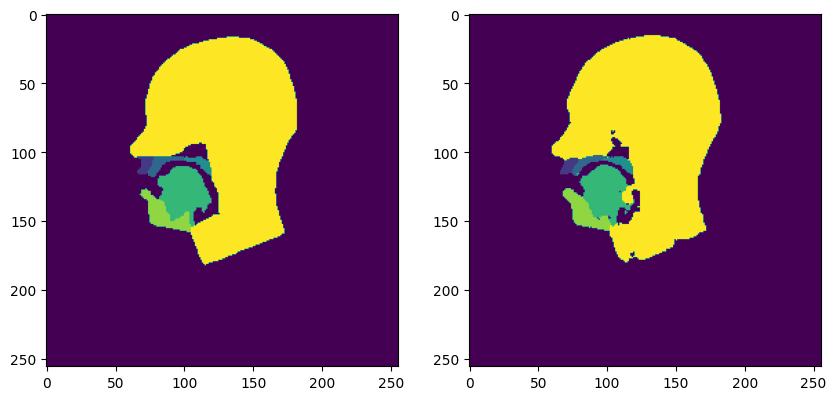

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.math.argmax(y_test[30], axis=-1))
plt.subplot(1, 2, 2)
plt.imshow(tf.math.argmax(predictions[30], axis=-1))

## Postprocessing

In [ ]:
"""TODO!"""

## Predictions Plotting

In [ ]:
n = 0
for volume, label in zip(x_test, y_test):

    print("Img n°: ", n)

    fig = plt.figure(figsize = [23, 6])     #generate the withe figure (background)
    plt.subplot(2, (NUM_CLASSES + 1), 1)    #define the grid size (r, c, index) (index must be >= 1)
    plt.imshow(volume[:,:,0], cmap="gray")  #dsMRI image plotting

    for i in range(NUM_CLASSES): #iteration over classes for each image

        plt.subplot(2, (NUM_CLASSES + 1), i+2)  #index moving to identify the correct grid coordinate
        plt.imshow(label[:,:,i])                #Ground Truth plotting
        plt.subplot(2, (NUM_CLASSES + 1), i+10) #index moving to identify the correct grid coordinate
        plt.imshow(predictions[n,:,:,i])        # <--------- Here the predictions plotting

    n = n + 1
    plt.show(fig) #subplot figure plotting
n = 0

## Garbage collector


In [ ]:
del x_train, x_test, x_val, y_train, y_test, y_val
import gc
gc.collect()